In [13]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
load_dotenv() 

True

## Cycle Graph Creation

Prompt

In [14]:
from langchain.prompts import PromptTemplate

cycle_graph_generation_prompt = PromptTemplate.from_template(
    '''
    Create a cyclic dialogue graph where the conversation MUST return to an existing node.

    **CRITICAL: Response Specificity**
    Responses must acknowledge and build upon what the user has already specified:

    INCORRECT flow:
    - User: "I'd like to order a coffee"
    - Staff: "What would you like to order?" (TOO GENERAL - ignores that they specified coffee)

    CORRECT flow:
    - User: "I'd like to order a coffee"
    - Staff: "What kind of coffee would you like?" (GOOD - acknowledges they want coffee)

    Example of a CORRECT cyclic graph for a coffee shop:
    "edges": [
        {{ "source": 1, "target": 2, "utterances": ["Hi, I'd like to order a coffee"] }},
        {{ "source": 2, "target": 3, "utterances": ["A large latte please"] }},
        {{ "source": 3, "target": 4, "utterances": ["Yes, that's correct"] }},
        {{ "source": 4, "target": 5, "utterances": ["Here's my payment"] }},
        {{ "source": 5, "target": 2, "utterances": ["I'd like to order another coffee"] }}
    ],
    "nodes": [
        {{ "id": 1, "label": "welcome", "is_start": true, "utterances": ["Welcome! How can I help you today?"] }},
        {{ "id": 2, "label": "ask_coffee_type", "is_start": false, "utterances": ["What kind of coffee would you like?"] }},
        {{ "id": 3, "label": "confirm", "is_start": false, "utterances": ["That's a large latte. Is this correct?"] }},
        {{ "id": 4, "label": "payment", "is_start": false, "utterances": ["Great! That'll be $5. Please proceed with payment."] }},
        {{ "id": 5, "label": "completed", "is_start": false, "utterances": ["Thank you! Would you like another coffee?"] }}
    ]

    **Rules:**
    1) Responses must acknowledge what the user has already specified
    2) The final node MUST connect back to an existing node
    3) Each node must have clear purpose
    4) Return ONLY the JSON without commentary
    5) Graph must be cyclic - no dead ends
    6) All edges must connect to existing nodes
    7) The cycle point should make logical sense

    **Your task is to create a cyclic dialogue graph about the following topic:** {topic}.
    '''
)

In [15]:
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field
from typing import List, Optional
from langchain_core.output_parsers import JsonOutputParser

class Edge(BaseModel):
    source: int = Field(description="ID of the source node")
    target: int = Field(description="ID of the target node")
    utterances: str = Field(description="User's utterance that triggers this transition")

class Node(BaseModel):
    id: int = Field(description="Unique identifier for the node")
    label: str = Field(description="Label describing the node's purpose")
    is_start: bool = Field(description="Whether this is the starting node")
    utterances: List[str] = Field(description="Possible assistant responses at this node")

class DialogueGraph(BaseModel):
    edges: List[Edge] = Field(description="List of transitions between nodes")
    nodes: List[Node] = Field(description="List of nodes representing assistant states")


parser = JsonOutputParser(pydantic_object=DialogueGraph)


model = ChatOpenAI(model="gpt-4o", api_key=os.getenv("OPENAI_API_KEY"), base_url=os.getenv("OPENAI_BASE_URL"), temperature=0)

generate_graph_chain = cycle_graph_generation_prompt | model | parser



In [16]:
topic = "dialogue about a coffee shop"
graph = generate_graph_chain.invoke({"topic": topic})

In [17]:
def print_conversation_flow(graph):
    print("=== Conversation Flow ===\n")
    
    # Create a dictionary for quick node lookup
    nodes = {node['id']: node for node in graph['nodes']}
    
    # Create adjacency list for edges
    edge_dict = {}
    for edge in graph['edges']:
        if edge['source'] not in edge_dict:
            edge_dict[edge['source']] = []
        edge_dict[edge['source']].append(edge)
    
    # Find starting node (is_start = true)
    start_node = next(node for node in graph['nodes'] if node.get('is_start', False))
    
    # Print flow starting from first node
    def print_path(node_id, visited_edges=None):
        if visited_edges is None:
            visited_edges = set()
            
        current_node = nodes[node_id]
        outgoing_edges = edge_dict.get(node_id, [])
        
        for edge in outgoing_edges:
            edge_key = f"{edge['source']}-{edge['target']}"
            if edge_key in visited_edges:
                print(f"    [Cycle back to Node {edge['target']}]\n")
                continue
                
            visited_edges.add(edge_key)
            
            print(f"Node {node_id} ({current_node['label']}):")
            print(f"    Assistant: {current_node['utterances'][0]}")
            print(f"\nEdge {edge['source']} → {edge['target']}:")
            print(f"    User: {edge['utterances'][0]}")
            print(f"\nNode {edge['target']} ({nodes[edge['target']]['label']}):")
            print(f"    Assistant: {nodes[edge['target']]['utterances'][0]}")
            print("\n" + "-"*50 + "\n")
            
            print_path(edge['target'], visited_edges)
    
    print_path(start_node['id'])

# Example usage:


print_conversation_flow(graph)

=== Conversation Flow ===

Node 1 (welcome):
    Assistant: Welcome to our coffee shop! How can I assist you today?

Edge 1 → 2:
    User: Hi, I'd like to order a coffee

Node 2 (ask_coffee_type):
    Assistant: What type of coffee would you like to order?

--------------------------------------------------

Node 2 (ask_coffee_type):
    Assistant: What type of coffee would you like to order?

Edge 2 → 3:
    User: A cappuccino, please

Node 3 (confirm_order):
    Assistant: You've chosen a cappuccino. Is that correct?

--------------------------------------------------

Node 3 (confirm_order):
    Assistant: You've chosen a cappuccino. Is that correct?

Edge 3 → 4:
    User: Yes, that's correct

Node 4 (process_payment):
    Assistant: Great choice! That will be $4. Please proceed with payment.

--------------------------------------------------

Node 4 (process_payment):
    Assistant: Great choice! That will be $4. Please proceed with payment.

Edge 4 → 5:
    User: Here's my paymen

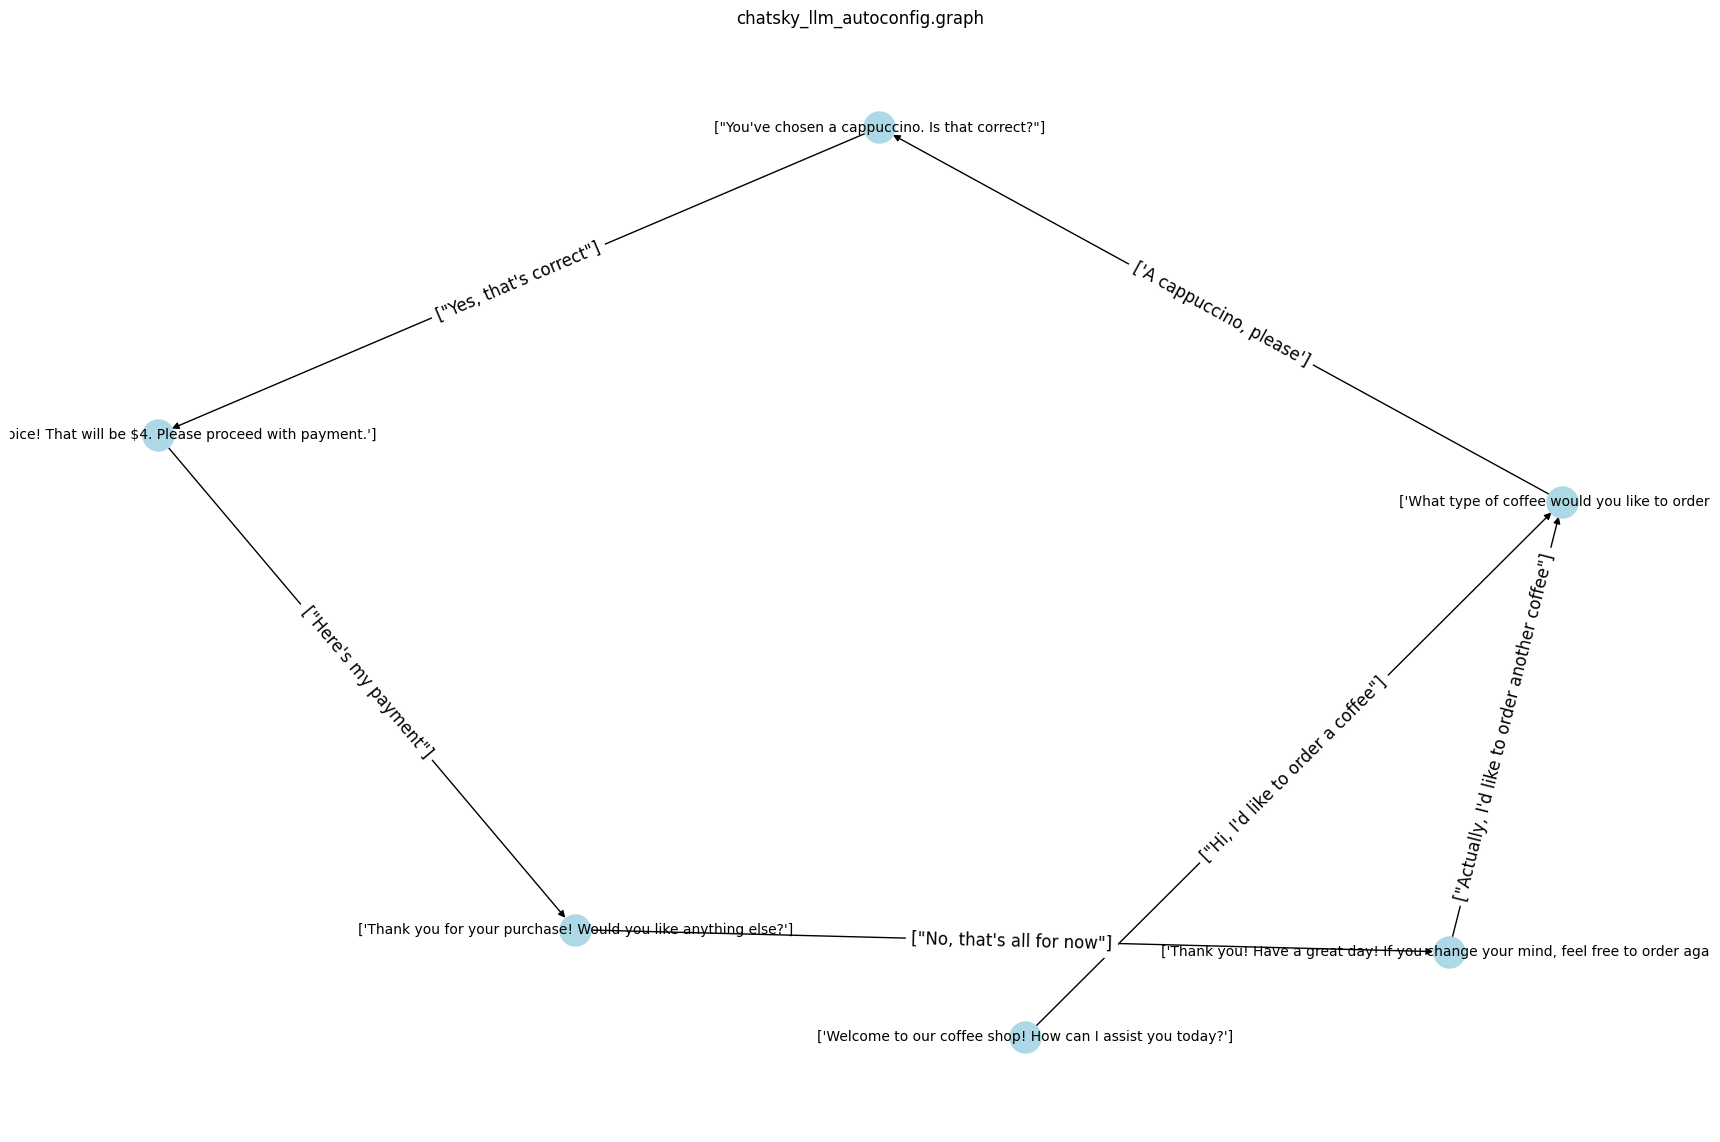

In [18]:
from chatsky_llm_autoconfig.graph import Graph
converted_graph =  Graph(graph)
converted_graph.visualise()

In [19]:
graph

{'edges': [{'source': 1,
   'target': 2,
   'utterances': ["Hi, I'd like to order a coffee"]},
  {'source': 2, 'target': 3, 'utterances': ['A cappuccino, please']},
  {'source': 3, 'target': 4, 'utterances': ["Yes, that's correct"]},
  {'source': 4, 'target': 5, 'utterances': ["Here's my payment"]},
  {'source': 5, 'target': 6, 'utterances': ["No, that's all for now"]},
  {'source': 6,
   'target': 2,
   'utterances': ["Actually, I'd like to order another coffee"]}],
 'nodes': [{'id': 1,
   'label': 'welcome',
   'is_start': True,
   'utterances': ['Welcome to our coffee shop! How can I assist you today?']},
  {'id': 2,
   'label': 'ask_coffee_type',
   'is_start': False,
   'utterances': ['What type of coffee would you like to order?']},
  {'id': 3,
   'label': 'confirm_order',
   'is_start': False,
   'utterances': ["You've chosen a cappuccino. Is that correct?"]},
  {'id': 4,
   'label': 'process_payment',
   'is_start': False,
   'utterances': ['Great choice! That will be $4. Pleas

## Best Graph Selection

In [20]:
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import List, Tuple
import os

def is_graph_valid(graph: DialogueGraph, topic: str) -> dict:
    """
    Validates the dialog graph structure and logical transitions between nodes.

    Parameters:
        graph (dict): A dictionary containing 'nodes' and 'edges' of the graph.
        topic (str): The topic of the dialog.

    Returns:
        dict: {'isValid': bool, 'description': str}
    """
    # Create a mapping from node IDs to node data for quick access
    node_map = {node['id']: node for node in graph['nodes']}
    overall_valid = True
    descriptions = []

    for edge in graph['edges']:
        source_id = edge['source']
        target_id = edge['target']
        edge_utterances = edge['utterances']

        # Check if source and target nodes exist
        if source_id not in node_map:
            description = f"Invalid edge: source node {source_id} does not exist."
            print(description)
            overall_valid = False
            descriptions.append(description)
            continue
        if target_id not in node_map:
            description = f"Invalid edge: target node {target_id} does not exist."
            print(description)
            overall_valid = False
            descriptions.append(description)
            continue

        source_node = node_map[source_id]
        target_node = node_map[target_id]

        # Get utterances from nodes
        source_utterances = source_node.get('utterances', [])
        target_utterances = target_node.get('utterances', [])

        # Validate the transition
        isValid, description = validate_transition(source_utterances, edge_utterances, target_utterances, topic)
        if not isValid:
            overall_valid = False
            description = f"Invalid transition from {source_utterances} to {target_utterances} via edge '{edge_utterances}': {description}"
            print(description)
            descriptions.append(description)

    result = {
        'isValid': overall_valid,
        'description': ' '.join(descriptions) if descriptions else 'All transitions are valid.'
    }
    return result

prompt_template = """
You are given a dialog between assistant and a user.
source_utterances, edge_utterances, target_utterances are dialog parts and each contains an array with exactly one utterance.
They should be read left to right.

- source_utterances are assistant phrases 
- edge_utterances are user phrases
- target_utterances are assistant phrases 

TASK. Evaluate if the transition makes a logical connection when reading from Source utterances to Target utterances through Edge utterances

this is an invalid transition:
{{
    'source_utterances': ['Welcome to our online bookstore. How can I assist you today?'],
    'edge_utterances': ['Hello! Are you looking for any book recommendations?'],
    'target_utterances': ['We have a wide selection of genres. Which do you prefer?'],
    'topic': 'Dialog about purchasing books between assistant and customer'
}}

Provide your answer in the following JSON format:
{{"isValid": true or false, "description": "Explanation of why it's valid or invalid."}}

Dialog topic: {topic}

(source_utterances) {source_utterances} -> (edge_utterances) {edge_utterances} -> (target_utterances) {target_utterances}

Your answer:"""

prompt = PromptTemplate(
    input_variables=["source_utterances", "edge_utterances", "target_utterances", "topic"],
    template=prompt_template,
)

class TransitionValidationResult(BaseModel):
    isValid: bool = Field(description="Whether the transition is valid or not.")
    description: str = Field(description="Explanation of why it's valid or invalid.")

# Initialize the output parser
parser = PydanticOutputParser(pydantic_object=TransitionValidationResult)


# Define the validate_transition function
def validate_transition(source_utterances: List[str], edge_utterances: str, target_utterances: List[str], topic: str) -> Tuple[bool, str]:
    """
    Validates a single transition in the graph using the language model.

    Parameters:
        source_utterances (List[str]): Utterances from the source node (assistant).
        edge_utterance (str): The utterance on the edge (user).
        target_utterances (List[str]): Utterances from the target node (assistant).
        topic (str): The topic of the dialog.

    Returns:
        Tuple[bool, str]: isValid and description.
    """
    # Prepare input data for the chain
    input_data = {
        "source_utterances": source_utterances,
        "edge_utterances": edge_utterances,
        "target_utterances": target_utterances,
        "topic": topic
    }
    
    model = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"), base_url=os.getenv("OPENAI_BASE_URL"), temperature=0)

    
    triplet_check_chain = prompt | model | parser

    
    response = triplet_check_chain.invoke(input_data)
    
    isValid = response.isValid
    description = response.description
    return isValid, description


result = is_graph_valid(graph, topic)
print(result)


{'isValid': True, 'description': 'All transitions are valid.'}


## Sampling

In [21]:
import random
from chatsky_llm_autoconfig.sample_dialogue import DialogueSampler

converted_graph =  Graph(graph)


sampler = DialogueSampler()
all_dialogues = sampler.invoke(converted_graph, 1, topic=topic)

dialogue = all_dialogues[0].dialogue

In [22]:
dialogue

[{'text': 'Welcome to our coffee shop! How can I assist you today?',
  'participant': 'assistant'},
 {'text': "Hi, I'd like to order a coffee", 'participant': 'user'},
 {'text': 'What type of coffee would you like to order?',
  'participant': 'assistant'},
 {'text': 'A cappuccino, please', 'participant': 'user'},
 {'text': "You've chosen a cappuccino. Is that correct?",
  'participant': 'assistant'},
 {'text': "Yes, that's correct", 'participant': 'user'},
 {'text': 'Great choice! That will be $4. Please proceed with payment.',
  'participant': 'assistant'},
 {'text': "Here's my payment", 'participant': 'user'},
 {'text': 'Thank you for your purchase! Would you like anything else?',
  'participant': 'assistant'},
 {'text': "No, that's all for now", 'participant': 'user'},
 {'text': 'Thank you! Have a great day! If you change your mind, feel free to order again.',
  'participant': 'assistant'},
 {'text': "Actually, I'd like to order another coffee", 'participant': 'user'}]

## Dialogue Augmentation

In [ ]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from typing import List, Dict, Any

augmentation_prompt = PromptTemplate.from_template("""
You are tasked with augmenting a dialogue by adding variations to existing utterances while maintaining the original dialogue flow and intent.

THEME: {topic}

INPUT DIALOGUE:
{dialogue}

INSTRUCTIONS:
1. For each message in the dialogue:
   - Keep the same structure (participant, source, target if present)
   - Create variation of the 'text' field that:
     * Express the same meaning/intent
     * Use different wording and phrasing
     * Match the given theme
     * Sound natural and conversational

2. The output must be a list of dictionaries, where each dictionary has:
   - 'text': string
   - 'participant': either 'user' or 'assistant'
   
3. Ensure all utterance variations:
   - Are appropriate for the theme
   - Maintain consistency in tone and style
   - Make sense in the conversation flow

Return ONLY a valid JSON array containing the augmented dialogue messages. Each message should be in this exact format:
For assistant messages: {{"text": "utterance text", "participant": "assistant"}}
For user messages: {{"text": "utterance text", "participant": "user"}}

Example format:
[
    {{"text": "How may I assist you today?", "participant": "assistant"}},
    {{"text": "I need help with a package", "participant": "user"}},
    {{"text": "What kind of package is it?", "participant": "assistant"}}
]
""")

class DialogueMessage(BaseModel):
    text: str
    participant: str

class DialogueSequence(BaseModel):
    result: List[DialogueMessage]

parser = JsonOutputParser(pydantic_object=DialogueSequence)

# Usage
model = ChatOpenAI(
    model="gpt-4o-mini", 
    api_key=os.getenv("OPENAI_API_KEY"), 
    base_url=os.getenv("OPENAI_BASE_URL"), 
    temperature=0.7
)

chain = augmentation_prompt | model | parser


result = chain.invoke({
    "topic": topic,
    "dialogue": dialogue
})

In [24]:
result

[{'text': 'Welcome to our coffee shop! How can I help you today?',
  'participant': 'assistant'},
 {'text': 'Hello! I would like to get a coffee', 'participant': 'user'},
 {'text': 'What kind of coffee would you like to have?',
  'participant': 'assistant'},
 {'text': "I'll have a cappuccino, please", 'participant': 'user'},
 {'text': "You've selected a cappuccino. Is that right?",
  'participant': 'assistant'},
 {'text': "Yes, that's right", 'participant': 'user'},
 {'text': 'Excellent choice! That comes to $4. Please go ahead with the payment.',
  'participant': 'assistant'},
 {'text': "Here's my payment for that", 'participant': 'user'},
 {'text': 'Thank you for your order! Would you like to add anything else?',
  'participant': 'assistant'},
 {'text': "No, that's everything for now", 'participant': 'user'},
 {'text': 'Thanks! Enjoy your day! If you change your mind, feel free to place another order.',
  'participant': 'assistant'},
 {'text': 'Actually, I’d like to get another coffe